# Importing Libaries

In [1]:
!pip install pandas matplotlib nltk spacy gensim tensorflow
!pip install textblob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.2 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import spacy
import gensim
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import string
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from matplotlib_venn import venn3
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from heapq import nlargest
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!python -m spacy download en_core_web_sm

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

2024-08-14 21:09:41.638995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 21:09:41.639113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 21:09:41.764720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Load CSV**

In [3]:

df = pd.read_csv("/kaggle/input/twitter/Twitter_News_Data.csv")
df.sample(10)
df.columns

Index(['link', 'text', 'user', 'likes', 'retweets', 'comments'], dtype='object')

In [4]:
# prompt: Do preprocessing to the dataset with Tokenization, lemmatization and stop words removal

# Tokenization
df['tokenized_text'] = df['text'].apply(nltk.word_tokenize)

# Lemmatization
nlp = spacy.load("en_core_web_sm")
df['lemmatized_text'] = df['tokenized_text'].apply(lambda tokens: [token.lemma_ for token in nlp(" ".join(tokens))])

# Stop words removal
stop_words = nltk.corpus.stopwords.words('english')
df['processed_text'] = df['lemmatized_text'].apply(lambda tokens: [token for token in tokens if token not in stop_words])


# **Explore dataset**

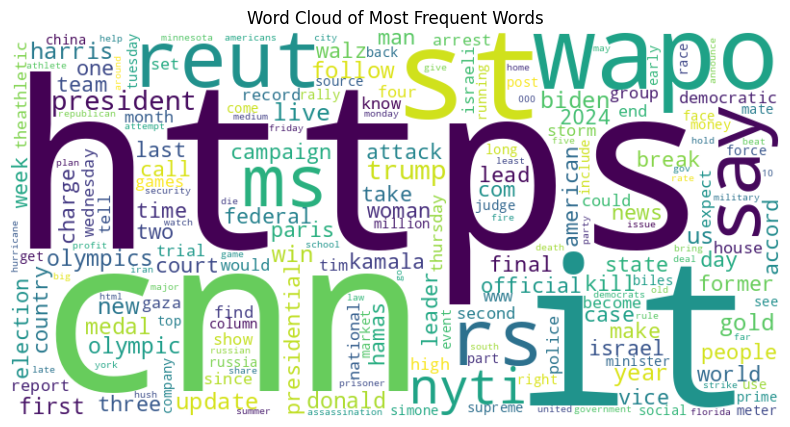

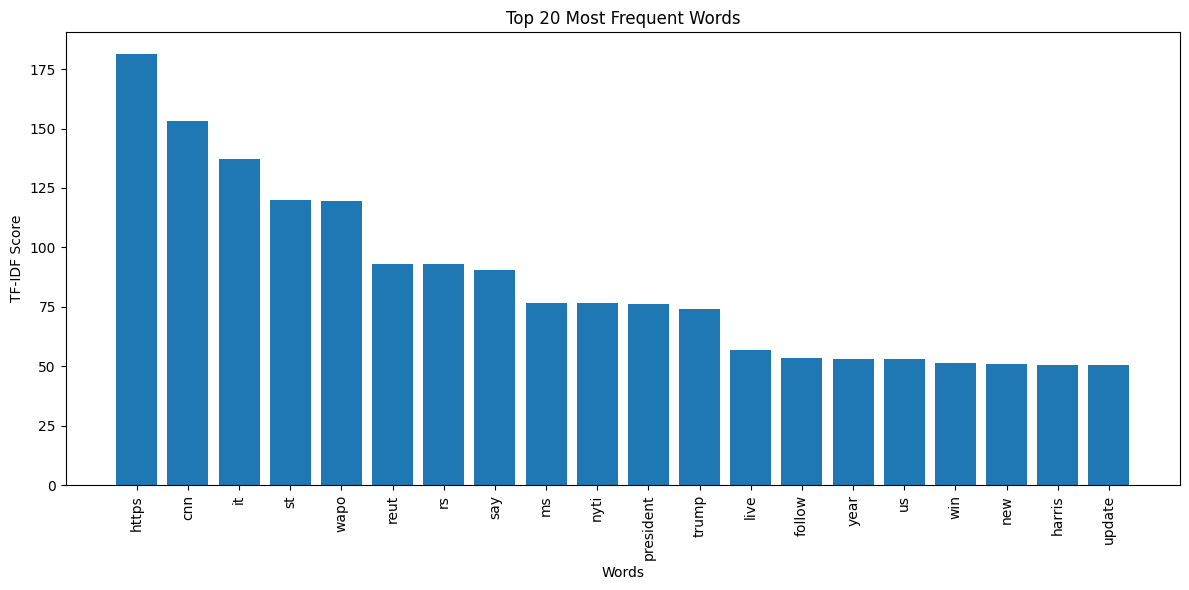

In [5]:
# prompt: Explore dataframe for NLP analysis, show graphs using matplotlib, this is my columns:['link', 'text', 'user', 'likes', 'retweets', 'comments'] use tf-idf, show word cloud and bar chart for most frequent words after proccessing


# Join processed tokens back into sentences
df['processed_text_joined'] = df['processed_text'].apply(lambda tokens: ' '.join(tokens))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['processed_text_joined'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Sum TF-IDF scores across all documents for each word
word_scores = tfidf_matrix.sum(axis=0).A1

# Create a dictionary of word and their scores
word_score_dict = dict(zip(feature_names, word_scores))

# Sort words by scores in descending order
sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

# Wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_score_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

# Bar chart for top N words
top_n = 20  # Change this to show more or fewer words
top_words = [word for word, score in sorted_words[:top_n]]
top_scores = [score for word, score in sorted_words[:top_n]]

plt.figure(figsize=(12, 6))
plt.bar(top_words, top_scores)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title(f'Top {top_n} Most Frequent Words')
plt.tight_layout()
plt.show()


## **finding frequent words using Word2Vec**


In [6]:
# prompt: use word2vec algorithm to find frequent words and show the stats(save them for future use), use organized formated text, remove punctioations



# Remove punctuations
df['no_punct_text'] = df['processed_text_joined'].apply(lambda text: ''.join([char for char in text if char not in string.punctuation]))

# Word2Vec Model
sentences = [sentence.split() for sentence in df['no_punct_text']]
model = gensim.models.Word2Vec(sentences, min_count=1, vector_size=100, workers=4)

# Finding Frequent Words
# (Word2Vec doesn't directly give frequency, but we can use most_similar to find related words)
similar_words = model.wv.most_similar('news', topn=20)

# Displaying Stats
print("Top 20 words most similar to 'news':")
for word, similarity in similar_words:
  print(f"- {word}: {similarity:.4f}")

# Saving the Model
model.save("word2vec.model")

print("\nWord2Vec model saved as 'word2vec.model'")


Top 20 words most similar to 'news':
- stand: 0.9990
- say: 0.9989
- election: 0.9988
- protester: 0.9986
- term: 0.9986
- ago: 0.9985
- son: 0.9985
- begin: 0.9985
- criminal: 0.9985
- Republican: 0.9984
- soon: 0.9984
- poll: 0.9984
- politic: 0.9983
- inside: 0.9983
- Tuesday: 0.9982
- Pennsylvania: 0.9982
- look: 0.9982
- case: 0.9982
- Republicans: 0.9982
- National: 0.9980

Word2Vec model saved as 'word2vec.model'


## AUTOENCODER algorithm

In [7]:
# prompt: use AUTOENCODER to find the most important words



# Reshape TF-IDF matrix for autoencoder input (assuming it's 2D)
tfidf_matrix_reshaped = tfidf_matrix.toarray()

# Scale the data
scaler = MinMaxScaler()
tfidf_scaled = scaler.fit_transform(tfidf_matrix_reshaped)

# Define the autoencoder architecture
input_dim = tfidf_scaled.shape[1]
encoding_dim = 32  # Adjust this based on your data and needs

input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = Dense(input_dim, activation='sigmoid')(encoder_layer)

autoencoder = Model(inputs=input_layer, outputs=decoder_layer)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(tfidf_scaled, tfidf_scaled, epochs=50, batch_size=32)  # Adjust epochs and batch size as needed

# Get the encoded representation of the data
encoder = Model(inputs=input_layer, outputs=encoder_layer)
encoded_data = encoder.predict(tfidf_scaled)

# Calculate the reconstruction error for each word
reconstruction_errors = np.mean(np.square(tfidf_scaled - autoencoder.predict(tfidf_scaled)), axis=0)

# Sort words by reconstruction error (higher error indicates more importance)
word_importance = dict(zip(feature_names, reconstruction_errors))
sorted_words_importance = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)

# Print top N important words
top_n = 20
print(f"Top {top_n} most important words based on autoencoder reconstruction error:")
for word, error in sorted_words_importance[:top_n]:
    print(f"- {word}: {error:.4f}")


Epoch 1/50


I0000 00:00:1723669996.026558     164 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


158/158 [==============================] - 3s 6ms/step - loss: 0.0946
Epoch 2/50
158/158 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 3/50
158/158 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 4/50
158/158 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 5/50
158/158 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 6/50
158/158 [==============================] - 1s 3ms/step - loss: 9.7002e-04
Epoch 7/50
158/158 [==============================] - 1s 3ms/step - loss: 9.3896e-04
Epoch 8/50
158/158 [==============================] - 1s 4ms/step - loss: 9.1922e-04
Epoch 9/50
158/158 [==============================] - 1s 4ms/step - loss: 9.0583e-04
Epoch 10/50
158/158 [==============================] - 1s 3ms/step - loss: 8.9633e-04
Epoch 11/50
158/158 [==============================] - 1s 3ms/step - loss: 8.8939e-04
Epoch 12/50
158/158 [==============================] - 1s 3ms/step - loss: 8.8413e-04
Epoch 13

# Comparing the Results of Word2Vec, AutoEncoder and Preproccesing

Common words between TF-IDF and Word2Vec: {'say'}
Common words between TF-IDF and Autoencoder: {'president', 'trump', 'harris', 'say', 'year', 'live'}
Common words between Word2Vec and Autoencoder: {'say'}
Common words across all methods: {'say'}


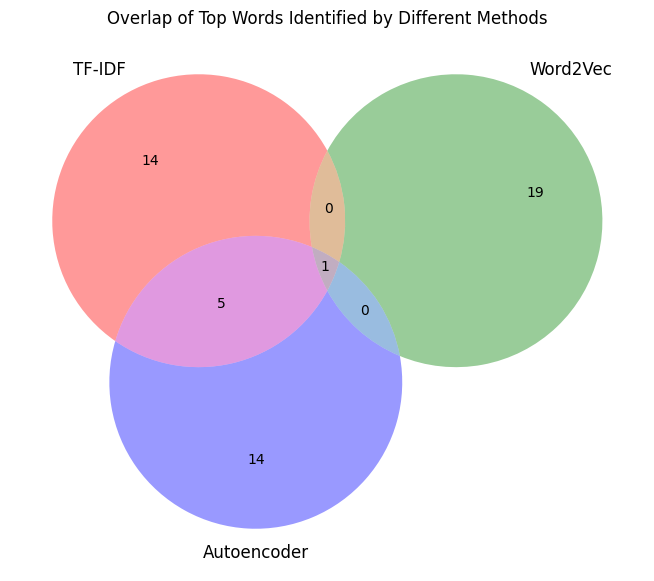

In [8]:
# prompt: Create a comparison between the result of autoencoder, word2vec and preprocessing
# # - Calculate overlap between the lists (common words)
# # - Visualize the word sets using Venn diagrams or UpSet plots
# # - Analyze the semantic or contextual differences between the words identified by each method

# Get top N words from each method
top_n = 20

# Preprocessing (TF-IDF)
top_words_tfidf = [word for word, score in sorted_words[:top_n]]

# Word2Vec
top_words_word2vec = [word for word, similarity in similar_words]

# Autoencoder
top_words_autoencoder = [word for word, error in sorted_words_importance[:top_n]]

# Calculate overlap
common_words_tfidf_word2vec = set(top_words_tfidf).intersection(top_words_word2vec)
common_words_tfidf_autoencoder = set(top_words_tfidf).intersection(top_words_autoencoder)
common_words_word2vec_autoencoder = set(top_words_word2vec).intersection(top_words_autoencoder)
all_common_words = set(top_words_tfidf).intersection(top_words_word2vec, top_words_autoencoder)

print("Common words between TF-IDF and Word2Vec:", common_words_tfidf_word2vec)
print("Common words between TF-IDF and Autoencoder:", common_words_tfidf_autoencoder)
print("Common words between Word2Vec and Autoencoder:", common_words_word2vec_autoencoder)
print("Common words across all methods:", all_common_words)

# Visualize using Venn diagram


plt.figure(figsize=(10, 7))
venn3([set(top_words_tfidf), set(top_words_word2vec), set(top_words_autoencoder)],
      set_labels=('TF-IDF', 'Word2Vec', 'Autoencoder'))
plt.title("Overlap of Top Words Identified by Different Methods")
plt.show()




# Sentiment Analysis

In [9]:
# prompt: Implement an algorithm to find NER


# Load the spaCy model (assuming you have 'en_core_web_sm' downloaded)
nlp = spacy.load("en_core_web_sm")

# Example text (replace with your actual text)
text = df['processed_text_joined'][0]

# Process the text with spaCy
doc = nlp(text)

# Extract named entities
named_entities = [(ent.text, ent.label_) for ent in doc.ents]

# Print the named entities
print("Named Entities:")
for entity, label in named_entities:
  print(f"- {entity} ({label})")


Named Entities:
- New York Times (ORG)
- Twitter (PRODUCT)


# EDA on the DATA, posts count by user and Sentiment Analysis by User(No Dates on my Dataset)

Number of posts by each user:
 user
The Washington Post    1642
CNN                    1632
Reuters                 842
The New York Times      766
The Athletic             10
                       ... 
Juliet Macur              1
Kevin Roose               1
Tara Siegel Bernard       1
Alan Feuer                1
Andrew Keh                1
Name: count, Length: 82, dtype: int64


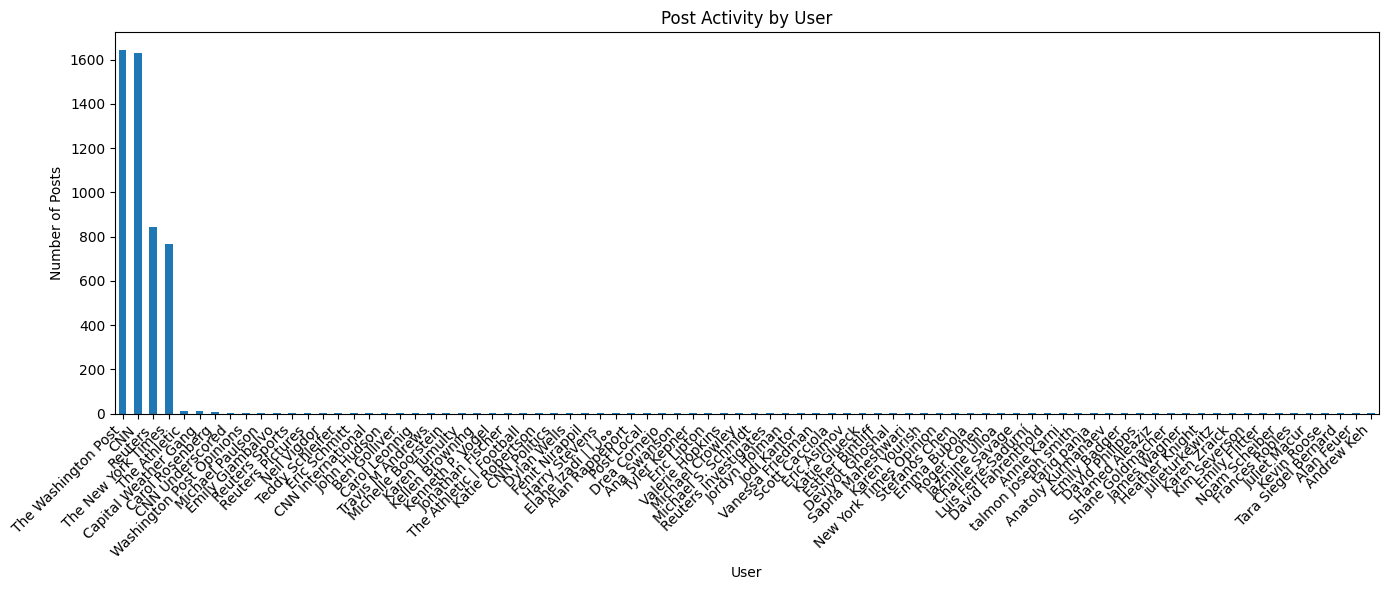


Average post length by each user:
 user
Alan Feuer                  37.0
Alan Rappeport              52.0
Ana Swanson                 62.0
Anatoly Kurmanaev           47.0
Andrew Keh                  59.0
                            ... 
Vanessa Friedman            33.0
Washington Post Opinions    40.0
julieturkewitz              69.0
talmon joseph smith         47.0
tariq panja                 51.0
Name: post_length, Length: 82, dtype: float64

Average sentiment for each user:
 user
Alan Feuer                 -0.062500
Alan Rappeport             -0.005303
Ana Swanson                -0.024242
Anatoly Kurmanaev           0.000000
Andrew Keh                  0.143750
                              ...   
Vanessa Friedman            0.000000
Washington Post Opinions    0.129167
julieturkewitz              0.047321
talmon joseph smith         0.255682
tariq panja                 0.100000
Name: sentiment, Length: 82, dtype: float64


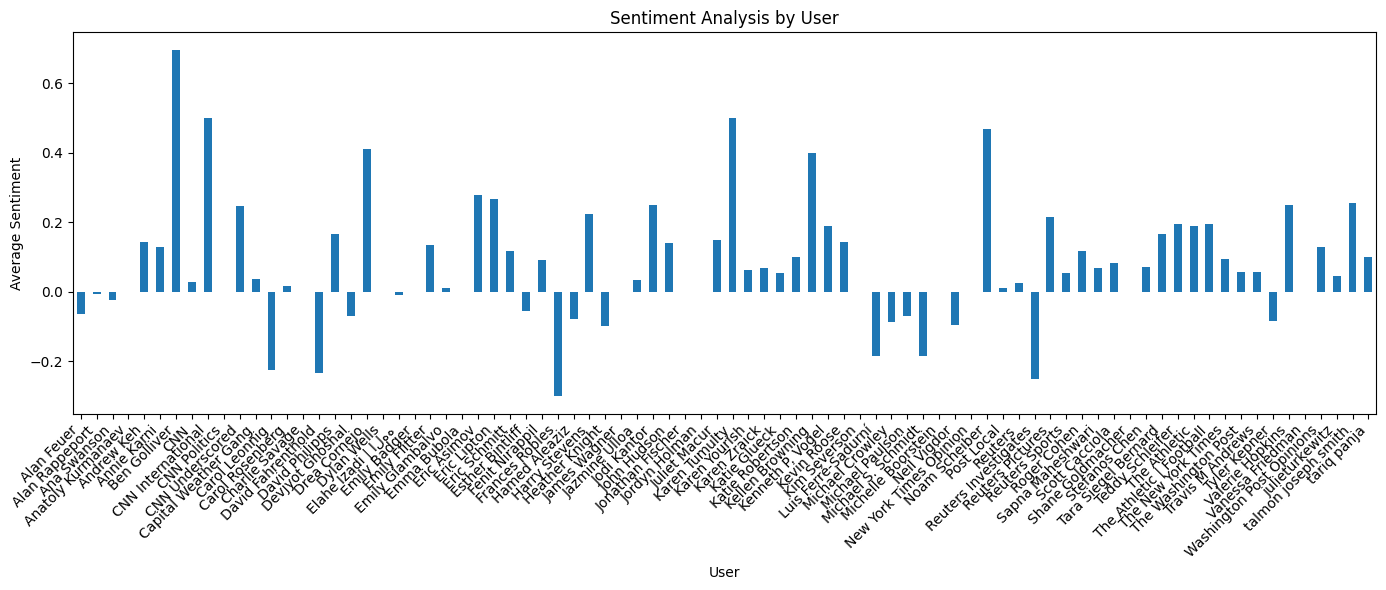

In [10]:

# **1. User-Based EDA**

# User Activity
user_post_counts = df['user'].value_counts()
print("Number of posts by each user:\n", user_post_counts)

plt.figure(figsize=(14, 6))
user_post_counts.plot(kind='bar')
plt.xlabel('User')
plt.ylabel('Number of Posts')
plt.title('Post Activity by User')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Average Post Length
df['post_length'] = df['processed_text_joined'].apply(lambda text: len(text.split()))
average_post_length_by_user = df.groupby('user')['post_length'].mean()
print("\nAverage post length by each user:\n", average_post_length_by_user)

# **2. Sentiment Analysis**

# Sentiment analysis using TextBlob (install if needed)


df['sentiment'] = df['processed_text_joined'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Sentiment distribution for each user
user_sentiment = df.groupby('user')['sentiment'].mean()
print("\nAverage sentiment for each user:\n", user_sentiment)

plt.figure(figsize=(14, 6))
user_sentiment.plot(kind='bar')
plt.xlabel('User')
plt.ylabel('Average Sentiment')
plt.title('Sentiment Analysis by User')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# using Summarization on the data

In [11]:

from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from heapq import nlargest


# Define the list of users to summarize
target_users = ['The New York Times', 'Reuters', 'CNN', 'The Washington Post']

def summarize_user_posts(df, user, num_sentences=3):
    """Summarizes posts by a specific user."""
    user_posts = df[df['user'] == user]['processed_text_joined'].tolist()
    all_sentences = []
    
    for post in user_posts:
        all_sentences.extend(sent_tokenize(post))

    # Calculate word frequencies in a memory-efficient way
    word_frequencies = FreqDist(word.lower() for sentence in all_sentences for word in nltk.word_tokenize(sentence))
    
    # Remove stopwords and punctuation
    stop_words = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
    word_frequencies = {word: freq for word, freq in word_frequencies.items() if word not in stop_words}

    max_frequency = max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word] = word_frequencies[word] / max_frequency

    # Calculate sentence scores
    sentence_scores = {}
    for sentence in all_sentences:
        for word in nltk.word_tokenize(sentence.lower()):
            if word in word_frequencies.keys():
                if sentence not in sentence_scores.keys():
                    sentence_scores[sentence] = word_frequencies[word]
                else:
                    sentence_scores[sentence] += word_frequencies[word]

    # Select top sentences for summary
    summary_sentences = nlargest(num_sentences, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)
    
    # Explicitly release memory by deleting unnecessary variables
    del all_sentences, word_frequencies, sentence_scores

    return summary

# Filter the DataFrame to include only the target users
filtered_df = df[df['user'].isin(target_users)]

# Process and summarize posts for the target users
for user in target_users:
    summary = summarize_user_posts(filtered_df, user)
    print(f"\nSummary for {user}:\n{summary}")



Summary for The New York Times:
player must select four group four word without make three mistake . listen ` ` Headlines , '' bring big story day New York Times reporter cover , five minute . David Lynch , 78 - year - old co - creator groundbreaking series " Twin Peaks " director " Mulholland Drive " " Blue Velvet , " say Monday emphysema .

Summary for Reuters:
Nagasaki 's mayor say would stick decision exclude Israel 's ambassador Friday 's event mark city 's atomic bombing , though senior diplomat United States G7 nation say snub would keep away https : //reut.rs/4dbyLft Britain 's competition watchdog say start investigation whether Amazon 's partnership AI startup Anthropic raise competition , day begin similar probe Alphabet 's collaboration startup https : //reut.rs/3LWcTIH Russia say Ukraine launch armored assault Russia 's southern Kursk region , Moscow 's force respond region 's governor describe situation border ' controllable ' https : //reut.rs/3LWaFJq

Summary for CNN:


# RNN Model Training on the data

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, sequences, max_length):
        self.sequences = sequences
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        X = sequence[:-1]
        y = sequence[-1]
        
        # Handle sequences longer than max_length - 1
        if len(X) > self.max_length - 1:
            X = X[-(self.max_length - 1):]
        else:
            X = np.pad(X, (self.max_length - 1 - len(X), 0), 'constant')
        
        return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# Tokenize and create sequences
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(df['processed_text_joined'])
sequences = tokenizer.texts_to_sequences(df['processed_text_joined'])
vocab_size = len(tokenizer.word_index) + 1

# Truncate sequences to reduce memory usage
max_length = 20  # Reduce max length
sequences = [seq for seq in sequences if len(seq) > 1]

# Define batch size
batch_size = 64

# Create Dataset and DataLoader
dataset = TextDataset(sequences, max_length)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return output

# Model parameters
embedding_dim = 32  # Reduced embedding size
hidden_dim = 16
output_dim = vocab_size

# Initialize the model, loss function, and optimizer
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(data_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(data_loader)}], Loss: {loss.item():.4f}')

# Save model (optional)
torch.save(model.state_dict(), 'rnn_model.pth')


In [16]:
import torch
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text(model, tokenizer, seed_text, max_length, num_words, device):
    model.eval()  # Set the model to evaluation mode
    generated_text = seed_text
    
    for _ in range(num_words):
        # Convert the seed text into a sequence of integers
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        # Pad the sequence to match the input length of the model
        token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')
        # Convert to PyTorch tensor
        token_list = torch.tensor(token_list, dtype=torch.long).to(device)
        # Predict the next word
        with torch.no_grad():
            predicted_probs = model(token_list)
        predicted_word_index = torch.argmax(predicted_probs, dim=-1).item()
        # Find the word that corresponds to the predicted index
        predicted_word = tokenizer.index_word.get(predicted_word_index, '')
        # Append the predicted word to the seed text
        generated_text += " " + predicted_word
        # Stop if the model predicts a termination token (optional)
        if predicted_word in ['end', 'eos']:  # assuming 'end' or 'eos' is used as the termination token
            break
    
    return generated_text

# Example usage:
seed_text = "Breaking news"
max_length = 20  # Same as used during training
num_words_to_generate = 15  # Number of words you want to generate

# Generate text using the trained RNN model
generated_text = generate_text(model, tokenizer, seed_text, max_length, num_words_to_generate, device)
print("Generated Tweet:", generated_text)


Generated Tweet: Breaking news rs ms st ms st ms st ms st ms st ms st ms st


In [18]:
# Flushing GPU Memory
def flush_gpu_memory():
    torch.cuda.empty_cache()
    print("GPU memory flushed.")

# After training or generation, you can call
flush_gpu_memory()

GPU memory flushed.


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, sequences, max_len):
        self.sequences = sequences
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return torch.tensor(seq[:-1], dtype=torch.long), torch.tensor(seq[1:], dtype=torch.long)

# Tokenize and create sequences
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(df['processed_text_joined'])
sequences = tokenizer.texts_to_sequences(df['processed_text_joined'])
vocab_size = len(tokenizer.word_index) + 1
max_length = 20  # Reduced max length

# Filter sequences and pad them
sequences = [seq for seq in sequences if len(seq) > 1]
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

# Create the dataset and dataloader
dataset = TextDataset(padded_sequences, max_length)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + ffn_output)
        return self.dropout(x)

# Define the GPT-like model
class GPTModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_len):
        super(GPTModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        x = self.embedding(x) + self.pos_embedding(positions)
        x = x.transpose(0, 1)  # Required for MultiheadAttention (batch, seq_len, embed_dim) -> (seq_len, batch, embed_dim)
        for block in self.blocks:
            x = block(x)
        x = x.transpose(0, 1)  # (seq_len, batch, embed_dim) -> (batch, seq_len, embed_dim)
        return self.fc(x)

# Model instantiation and training setup
embed_dim = 32
num_heads = 2
ff_dim = 64
num_layers = 2
model_gpt = GPTModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_length).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model_gpt.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model_gpt(X)
        loss = criterion(outputs.view(-1, vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Text generation with the trained GPT-like model
def generate_gpt_text(model, tokenizer, seed_text, max_length, num_words):
    model.eval()
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    for _ in range(num_words):
        token_list_padded = pad_sequences([token_list], maxlen=max_length-1, padding='pre')
        token_list_tensor = torch.tensor(token_list_padded, dtype=torch.long).to(device)
        with torch.no_grad():
            predicted = model(token_list_tensor)
        predicted_word_index = torch.argmax(predicted[:, -1, :], dim=-1).item()
        token_list.append(predicted_word_index)
    return ' '.join([tokenizer.index_word.get(i, '') for i in token_list])





Using device: cuda
Epoch [1/30], Loss: 9.7211
Epoch [2/30], Loss: 9.7119
Epoch [3/30], Loss: 9.7585
Epoch [4/30], Loss: 9.7251
Epoch [5/30], Loss: 9.7454
Epoch [6/30], Loss: 9.7379
Epoch [7/30], Loss: 9.7172
Epoch [8/30], Loss: 9.7606
Epoch [9/30], Loss: 9.7027
Epoch [10/30], Loss: 9.7298
Epoch [11/30], Loss: 9.7438
Epoch [12/30], Loss: 9.7483
Epoch [13/30], Loss: 9.6913
Epoch [14/30], Loss: 9.7047
Epoch [15/30], Loss: 9.7204
Epoch [16/30], Loss: 9.6907
Epoch [17/30], Loss: 9.7280
Epoch [18/30], Loss: 9.7286
Epoch [19/30], Loss: 9.7406
Epoch [20/30], Loss: 9.7066
Epoch [21/30], Loss: 9.7398
Epoch [22/30], Loss: 9.7052
Epoch [23/30], Loss: 9.7778
Epoch [24/30], Loss: 9.7496
Epoch [25/30], Loss: 9.7081
Epoch [26/30], Loss: 9.7240
Epoch [27/30], Loss: 9.7265
Epoch [28/30], Loss: 9.7413
Epoch [29/30], Loss: 9.7145
Epoch [30/30], Loss: 9.7265


# Running GPT model to generate text

In [20]:
# Example of text generation
generated_text_GPT=generate_gpt_text(model_gpt, tokenizer, "Donald Trump", max_length, 20)
print(generated_text_GPT)

donald trump improperly marine delirious rehearse billing skepticism 3lz3sz2 3lz3sz2 3lz3sz2 improperly marine delirious rehearse poet cocaine 3ynlaow delirious rehearse poet cocaine


# comparing results on the same data

In [24]:
# Seed text and parameters
seed_text = "Breaking news"
max_length = 20  # Ensure this matches the max length used during training
num_words_to_generate = 15  # Number of words to generate

# Generate text using the RNN model
rnn_generated_text = generate_text(model, tokenizer, seed_text, max_length, num_words_to_generate, device)
print("Generated Text using RNN Model:\n", rnn_generated_text)

import torch
import numpy as np
from torch.nn.functional import softmax

def generate_text_gpt(model, tokenizer, seed_text, max_length, num_words, device):
    model.eval()  # Set the model to evaluation mode
    generated_text = seed_text
    
    # Tokenize and pad the seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')
    token_list = torch.tensor(token_list, dtype=torch.long).to(device)
    
    for _ in range(num_words):
        # Predict the next token
        with torch.no_grad():
            output = model(token_list)[0]  # Assuming model outputs (logits)
        
        # Get the logits for the next word
        logits = output[:, -1]  # Take logits for the last token
        predicted_probs = softmax(logits, dim=-1)
        predicted_word_index = torch.argmax(predicted_probs, dim=-1).item()
        
        # Find the word that corresponds to the predicted index
        predicted_word = tokenizer.index_word.get(predicted_word_index, '')
        
        # Append the predicted word to the seed text
        generated_text += " " + predicted_word
        
        # Update token list for the next iteration
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')
        token_list = torch.tensor(token_list, dtype=torch.long).to(device)
        
        # Stop if the model predicts a termination token (optional)
        if predicted_word in ['end', 'eos']:  # assuming 'end' or 'eos' is used as the termination token
            break
    
    return generated_text


# Generate text using the GPT model
gpt_generated_text = generate_text_gpt(model_gpt, tokenizer, seed_text, max_length, num_words_to_generate, device)
print("Generated Text using GPT Model:\n", gpt_generated_text)

Generated Text using RNN Model:
 Breaking news rs ms st ms st ms st ms st ms st ms st ms st
Generated Text using GPT Model:
 Breaking news reut wapo wapo reut live wapo trump win new live live trump trump new live
